In [2]:
#Import useful modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import random
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
#Set directory and import the Letters data
os.chdir('D:\MSc2\Deep Learning Keras\Task2')
data = pd.read_csv('Letters.txt',header=None)

#Randomly shuffle the data
data = data.iloc[np.random.permutation(data.shape[0]),].reset_index(drop=True)

In [4]:
#data.head() #First column is the label (binary)
#data.shape #(20000, 17)
#data.describe() #x = 0-15
#data.info() #y = object, x = int64
#data.columns.values #column names

In [5]:
##Section 1: Data cleaning and Exploratory Data Analysis
#Rename the columns 
data.columns = ["Class"] + ["Feature" + str(num1) for num1 in range(1,17)]

#Create features and labels
y = data['Class'].astype("category") #26 classes - pandas series (type categoy)
x = data.iloc[:,1:] #features 

d = dict(zip(y.unique(), range(0,26))) #{'A': 0, ..., 'Z': 25}
y = y.map(d, na_action='ignore') #map the labels of Y: Poissonous - 1, Others - 0

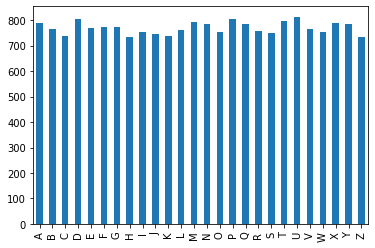

In [6]:
#Plot the Class Label distributions and the Feature distributions
#Class label distribution
label_dist = data.iloc[:,0].value_counts().sort_index() #create a table of counts 
label_dist.plot.bar() #balanced labels

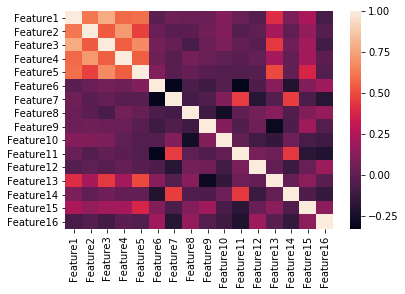

In [7]:
#Check correlation between features using a heat map
#pearson
#sns.heatmap(x.corr(method = 'pearson')) 

#kendall
sns.heatmap(x.corr(method = 'kendall'))

#not much correlated except features 1-5

C:\Users\ERIC\Anaconda3\envs\tensorflow_cpu\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


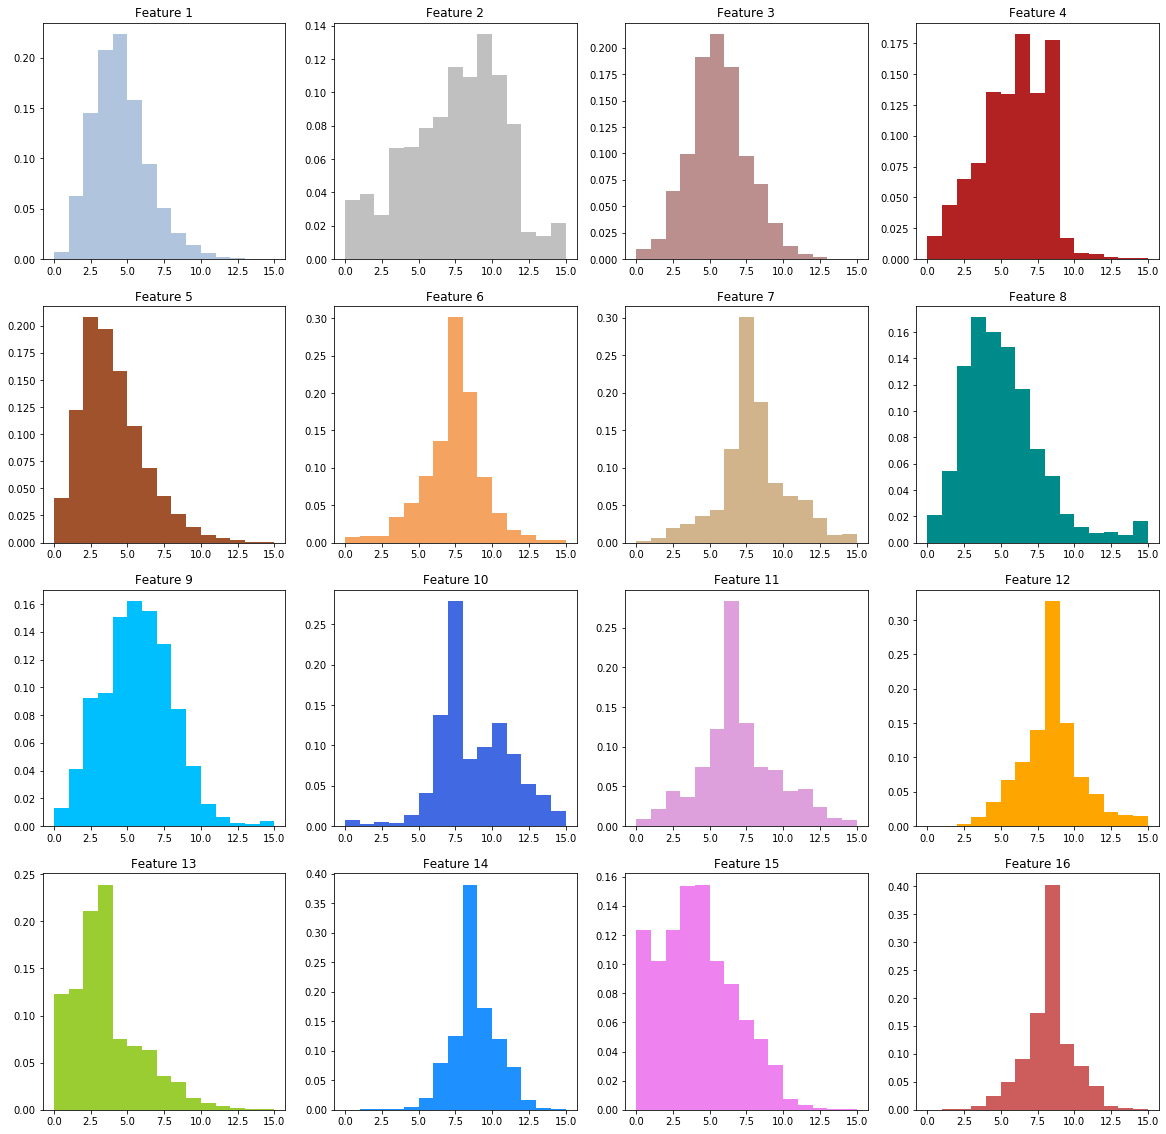

In [8]:
#check distribution of the features
#Plot all 16 Feature distribution
platte = ["silver","rosybrown","firebrick","sienna","sandybrown","tan","darkcyan","deepskyblue","royalblue","plum","orange",
"yellowgreen","dodgerblue","violet","indianred","lightsteelblue"]
f = plt.figure(figsize=(20,20))
for i in range(0,16): 
    plt.subplot(4, 4, i+1)
    plt.hist(x.iloc[:,i],normed=True,bins=15,color=platte[i-1])
    plt.title('Feature ' + str(i+1))

In [9]:
##Section 2. Prepare data for modelling
n = data.shape[0]
k = 0.70
q = int(round(n*k))

#First convert to numpy arrays and perform the train-test split (70%-30%)
x = np.asarray(x).astype('float64')
y = np.asarray(y) #objects

train_x = x[:q,:] 
test_x = x[q:,:] 
train_y = y[:q]
test_y = y[q:]

#Then standardize features and convert to numpy arrays
mean = train_x.mean(axis = 0)
std = train_x.std(axis = 0)

train_x = (train_x - mean)/std #scale the training data
test_x = (test_x - mean)/std #Note: scale the test data using quantities from the training data 
                              #to prevent information flow into the future (test data = future/unseen data)

In [10]:
#1-hot-encode targets y and convert to numpy arrays
y = to_categorical(y)

train_y = y[:q,:]
test_y = y[q:,:]

C:\Users\ERIC\Anaconda3\envs\tensorflow_cpu\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


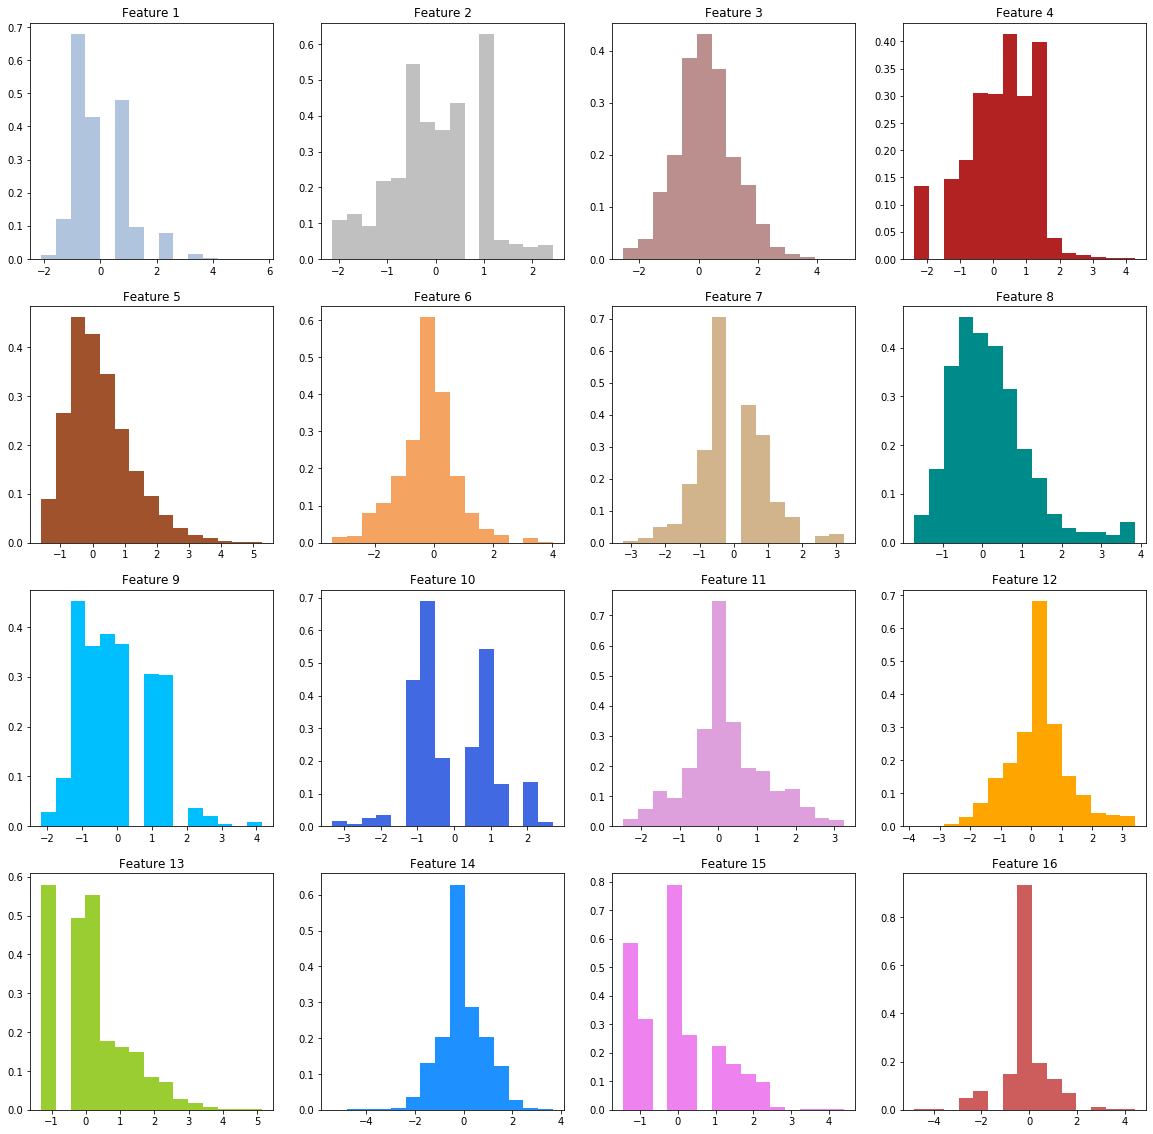

In [11]:
#type(train_x), type(train_y), type(test_x), type(test_y) #(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)
#train_x.shape, train_y.shape, test_x.shape, test_y.shape #((14000, 16), (14000, 26), (6000, 16), (6000, 26))
#type(train_x), type(train_y), type(test_x), type(test_y) #(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)
#train_x.shape, train_y.shape, test_x.shape, test_y.shape #((14000, 16), (14000, 26), (6000, 16), (6000, 26))
#verify the scaled data
#check distribution of the features
#Plot all 16 Feature distribution
platte = ["silver","rosybrown","firebrick","sienna","sandybrown","tan","darkcyan","deepskyblue","royalblue","plum","orange",
"yellowgreen","dodgerblue","violet","indianred","lightsteelblue"]
f = plt.figure(figsize=(20,20))
for i in range(0,16): 
    plt.subplot(4, 4, i+1)
    plt.hist(train_x[:,i],normed=True,bins=15,color=platte[i-1])
    plt.title('Feature ' + str(i+1))

In [13]:
##Section 3. Model Building
#1)Architecture of the model
n = 300 # number of epochs

def model_build():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_x.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(26, activation='softmax')) #26 classes
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #Optimizer, Loss function, Metrics
    return model

#2)Train the model 
##K-Fold CV 
k = 3
num_validation_samples = train_x.shape[0] // k
accuracy = []

for i in range(1,n,20): #Hyper-param = # of epochs
    a = []
    for fold in range(k): #5 folds
        validation_x = train_x[num_validation_samples*fold: num_validation_samples*(fold+1),:]
        validation_y = train_y[num_validation_samples*fold: num_validation_samples*(fold+1)]
        training_x = np.concatenate( (train_x[:num_validation_samples,:],train_x[num_validation_samples*(fold+1):,:]),
                                        axis = 0)
        training_y = np.concatenate( (train_y[:num_validation_samples],train_y[num_validation_samples*(fold+1):]),
                                        axis = 0)
        model = model_build()
        model.fit(training_x, training_y, epochs=i, batch_size=512,verbose=0) 

        a.append(model.evaluate(validation_x,validation_y,verbose=0)[1])
                
    accuracy.append(sum(a)/len(a))

No handles with labels found to put in legend.


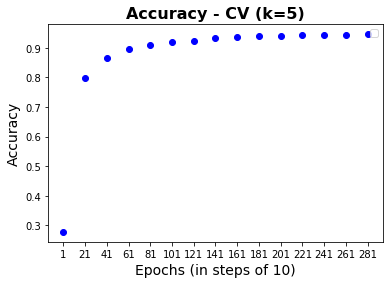

In [17]:
#3)Tuning - Plot loss and accuracy 
accuracy_values = np.asarray(accuracy)
epochs = range(1,n+1,20)
plt.plot(epochs,accuracy_values, 'bo')
plt.xticks(range(1,n+1,20))
plt.title('Accuracy - CV (k=5)', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs (in steps of 10)',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.legend()
plt.show()

In [18]:
#4)Finalize - retraining the model using whole training set
model = model_build()
model.fit(train_x, train_y, epochs=220,batch_size=512,verbose=0)

In [20]:
#5)Evaluate on the test set
model.evaluate(test_x,test_y) #[loss, accuracy] = [0.1814126917310059, 0.9453333333333334]

6000/6000 [==============================] - 1s 163us/step


[0.1814126917310059, 0.9453333333333334]

([array([5.742e+03, 1.400e+01, 4.000e+00, 3.000e+00, 4.000e+00, 7.000e+00,
         7.000e+00, 6.000e+00, 1.000e+01, 2.030e+02]),
  array([5.776e+03, 1.000e+01, 5.000e+00, 5.000e+00, 5.000e+00, 2.000e+00,
         3.000e+00, 3.000e+00, 5.000e+00, 1.860e+02]),
  array([5.749e+03, 8.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
         0.000e+00, 5.000e+00, 2.000e+00, 2.290e+02]),
  array([5.776e+03, 4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 6.000e+00,
         4.000e+00, 0.000e+00, 7.000e+00, 1.940e+02]),
  array([5.726e+03, 1.100e+01, 2.000e+00, 7.000e+00, 2.000e+00, 2.000e+00,
         6.000e+00, 3.000e+00, 4.000e+00, 2.370e+02]),
  array([5.758e+03, 1.100e+01, 8.000e+00, 5.000e+00, 8.000e+00, 1.000e+00,
         5.000e+00, 5.000e+00, 8.000e+00, 1.910e+02]),
  array([5.734e+03, 1.800e+01, 1.300e+01, 1.200e+01, 4.000e+00, 2.000e+00,
         2.000e+00, 7.000e+00, 8.000e+00, 2.000e+02]),
  array([5.744e+03, 5.000e+00, 5.000e+00, 0.000e+00, 4.000e+00, 1.000e+00,
         1.000e

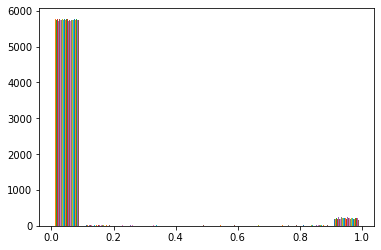

In [19]:
#6)Closer look at the test set performance
predictions = model.predict(test_x, verbose=0) #see the soft probability of the predicted data
plt.hist(predictions)

In [21]:
#Random baseline model(multiclass classification)
test_y = np.asarray(data.iloc[q:,0])
test_y_copy = copy.copy(test_y)
np.random.shuffle(test_y_copy)
hits_array = np.array(test_y) == np.array(test_y_copy)
float(np.sum(hits_array))/len(test_y)

#a random guess tends to get an accuracy of 0.04033333333333333

0.04033333333333333